In [12]:
%pylab inline
from datetime import date
from datetime import datetime
import os
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


/home/juanchosol1996/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'datetime', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
#Funciones para crear matrices de entrenaminto y pruebas

In [62]:
def train_X_Y(dia, deltas,dollar, d_inicial,num_samples,num_features):    ##d_inicial : 0 a 2508
    ##dias: vector de dia de la semana para cada dia (L=1...V=5)
    ##precios: vector de pecios para cada dia
    ##d_inicial: Primer dia del entrenamiento (0 a 2508) es num_features-1 dias antes que el primer Y de entrenamiento 
    ##num_samples: Número de muestras para entrenar 
    ##num_features: Número de parametros de entrenamiento (1+ número de dias con que se predice el precio)
    
    
    
    num_dias = num_features-2
   
    dias = dia[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    dias = dias.reshape(len(dias),1)
    dolar = dollar[d_inicial+num_dias-1:d_inicial+num_dias+num_samples-1]
    dolar = dolar.reshape(len(dolar),1)
    
    
    d=deltas[d_inicial:d_inicial+num_samples]
    
    for i in range(d_inicial+1,d_inicial+num_dias):
        m = deltas[i:i+num_samples]
        d =  np.column_stack((d,m))       
    d = np.column_stack((d,dias))
    X = np.column_stack((d,dolar))
             
    Y = deltas[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    
    assert (X.shape == (num_samples, num_features))
    assert (Y.shape == (num_samples,))
    
    train = {"X": X,
             "Y": Y
            }
    
    return train



def test_X_Y(dias, deltas,dolar, d_inicial,num_samples,num_features):
    test = train_X_Y(dias, deltas,dolar, d_inicial,num_samples,num_features)
    
    return test

def cal_porcentaje(porcentajes):
    prcts=[]
    acum = porcentajes[0]
    prcts.append(acum)
    for i in range(1,len(porcentajes)):
        acum = acum*porcentajes[i]
        prcts.append(acum)
    
    prcts = np.array(prcts)
    return prcts


def errores(Y_expected,Y_predict):
    error_RMS= sqrt(mean_squared_error(Y_expected,Y_predict))
    error_MBE= mean(Y_expected-Y_predict)
    p_value = ks_2samp(Y_expected,Y_predict)[1]
                    
    error = {"RMS": error_RMS,
             "MBE": error_MBE,
             "P-Value": p_value
            }
    return error

def RMS(Y_prdct,Y):
    error = np.sqrt(sum((Y_prdct-Y)**2))/len(Y)
    return error

In [ ]:
## Poblando datos

In [3]:
datos_csv = os.path.join( '.','COLCAP.csv')
datos_pd = pd.read_csv(datos_csv, sep = ',',
                encoding='latin-1', parse_dates =[0], infer_datetime_format= True)
dolar_csv = os.path.join( '.','Dolar.csv')
dolar_pd = pd.read_csv(dolar_csv, sep = ',',
                encoding='latin-1', parse_dates =[0], infer_datetime_format= True)

In [4]:
fecha_o = datos_pd['Fecha (dd/mm/aaaa)']
fecha = dolar_pd['Fecha (dd/mm/aaaa)']
variacion = dolar_pd['Variación Porcentual']

var_dolar =[]
for i in range(len(fecha)):
    if sum(fecha[i] == fecha_o) == 1:
        var_dolar.append(variacion[i])
        
var_dolar = np.array(var_dolar)

In [5]:
a=datos_pd["Fecha (dd/mm/aaaa)"]

days = []

for i in range(len(a)):
    d = a[i].weekday() + 1
    days.append(d)
    
d = np.array(days)

In [6]:
c = datos_pd["Valor COLCAP"]
c = np.array(c)
for i in range(len(c)):
    c[i] = c[i].replace(',',"")


price=np.array(c, dtype= np.float64)

In [7]:
b = datos_pd["Variación porcentual"]
b = np.array(b)
for i in range(len(b)):
    b[i] = b[i].replace('%',"")


p=np.array(b, dtype= np.float64)

In [ ]:
## Prueba

In [18]:
#Definición de matrices de entreno
train=train_X_Y(d,p,var_dolar,1400,1000,11)

In [19]:
#Definición de matrices de prueba
test=test_X_Y(d,p,var_dolar,2450,30,11)

In [75]:
#Entreno del sistema
e = 10
rg = None
for l in range(10):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=(50,1), max_iter= 200, activation="relu",shuffle= False, solver= "adam", warm_start= False, tol=0.000001)
        r.fit(train["X"],train["Y"])
    error = errores(train['Y'],r.predict(train['X']))['RMS']
    
    if error<e:
        e=error
        rg=r
        print(e)
        

0.720692352585
0.711814151779
0.70067893096
0.684585530315


In [76]:
print(rg.n_iter_)
print(e)

200
0.684585530315


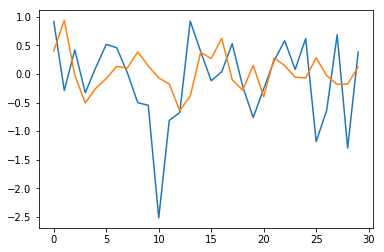

El Error RMS del entreno es: 0.684585530315
El Error MBE del entreno es: -0.0104406862612

El Error RMS de la prueba es: 0.796178991677
El Error MBE de la prueba es: -0.139139687049


In [77]:
#Grafica de predicción y real
y1 = np.array(test["Y"])
y2= np.array(rg.predict(test["X"]))
plt.plot(y1)
plt.plot(y2)
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))

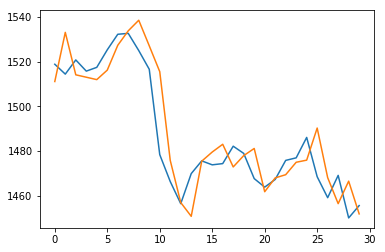

El Error RMS de la prueba es: 0.796178991677
El Error MBE de la prueba es: -0.139139687049


In [78]:
y_1=price[2450+9:2450+30+9]
preprice =price[2450+9-1:2450+30+9-1]
plt.plot(y_1[-30:])
prct = rg.predict(test["X"])/100+1
#prct = test["Y"]/100+1
#prct = cal_porcentaje(prct)

y_2 = preprice*prct
plt.plot(y_2[-30:])
plt.show()

error = errores(y1,y2)
print("El Error RMS de la prueba es: " + str(error['RMS']))
print("El Error MBE de la prueba es: " + str(error['MBE']))

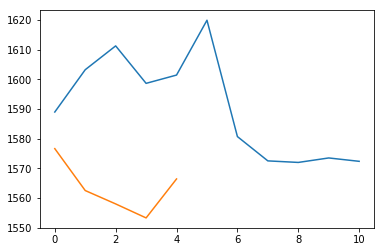

In [27]:
ant = np.array(p[-15:-6])
dia= d[-5]
X_predict = np. append(ant[0:],dia)
dol = var_dolar[-6]
X_predict = np. append(X_predict,dol)
X_predict = X_predict.reshape(1,11)

Y = rg.predict(X_predict)
ant=np.append(ant,Y)

for i in range(10):
    dia = dia+1
    if dia==6:
        dia=1
    
    v = np.append(ant[i+1:],dia)
    dol =var_dolar[-6+i]
    v = np.append(v,dol)
    v =v.reshape(1,11)
    X_predict= np.vstack((X_predict,v))
    Y = rg.predict(v)
    ant=np.append(ant,Y)
    
Y = rg.predict(X_predict)
prct =cal_porcentaje(Y/100+1)

plt.plot(price[-6]*prct)
plt.plot(price[-5:])

In [87]:
#Entreno del sistema lbfgs
e = 10
rg = None
for l in range(10):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=(100,3), max_iter= 200, activation="relu",shuffle= False, solver= "lbfgs", warm_start= False, tol=0.000001)
        r.fit(train["X"],train["Y"])
    error = errores(train['Y'],r.predict(train['X']))['RMS']
    
    if error<e:
        e=error
        rg=r
        print(e)
        

0.40384025166
0.403225207166
0.395003265497
0.384580856169


In [88]:
print(rg.n_iter_)
print(e)

201
0.384580856169


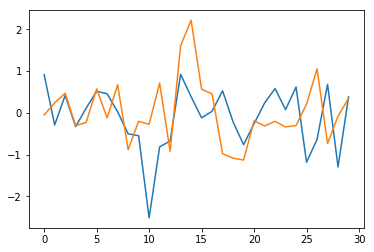

El Error RMS del entreno es: 0.384580856169
El Error MBE del entreno es: 0.00947257466327

El Error RMS de la prueba es: 0.960610816006
El Error MBE de la prueba es: -0.134745538278


In [89]:
#Grafica de predicción y real
y1 = np.array(test["Y"])
y2= np.array(rg.predict(test["X"]))
plt.plot(y1)
plt.plot(y2)
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))

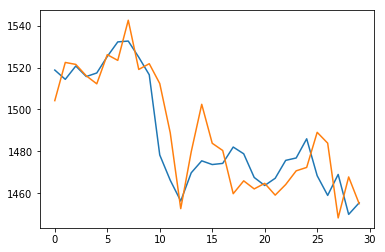

El Error RMS de la prueba es: 0.960610816006
El Error MBE de la prueba es: -0.134745538278


In [90]:
y_1=price[2450+9:2450+30+9]
preprice =price[2450+9-1:2450+30+9-1]
plt.plot(y_1[-30:])
prct = rg.predict(test["X"])/100+1
#prct = test["Y"]/100+1
#prct = cal_porcentaje(prct)

y_2 = preprice*prct
plt.plot(y_2[-30:])
plt.show()

error = errores(y1,y2)
print("El Error RMS de la prueba es: " + str(error['RMS']))
print("El Error MBE de la prueba es: " + str(error['MBE']))

In [91]:
#Prueba del modelo
rg.score(train["X"], train["Y"])

0.81114026507936632

In [92]:
rg.score(test["X"], test["Y"])

-0.70432598545046465

In [79]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='adam', tol=0.000001)
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(5):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
        
    c.append(clf.best_params_['hidden_layer_sizes'])
    
    print(c)

[(80, 1)]
[(80, 1), (100, 1)]
[(80, 1), (100, 1), (40, 1)]
[(80, 1), (100, 1), (40, 1), (30, 1)]
[(80, 1), (100, 1), (40, 1), (30, 1), (100, 3)]


In [65]:
# Mejor combinación Adam
c= []
conf = np.array([])
rep = np.array([])
for k in range(5):
    menor = 1000
    m=""
    for i in range (50,110,10):
        for j in range (1,11):

            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always") 
                rg = MLPRegressor(hidden_layer_sizes=(i,j), max_iter= 200, activation="relu",shuffle= False, solver= "adam",tol=0.000001)
                rg.fit(train["X"],train["Y"])

            if w==[]:
                error = errores(train['Y'],rg.predict(train['X']))['RMS']
                #print(str(i)+ ","+str(j)+" :" + str(error))

            if error<menor:
                menor = error
                m = (i,j) 
                
    print(m)
    c.append(m)
    print(" :" + str(menor))
print(c)

(50, 1)
 :0.496544300605
(90, 10)
 :0.527898127801
(50, 1)
 :0.538017855983
(100, 6)
 :0.517037305773
(90, 5)
 :0.554302292892
[(50, 1), (90, 10), (50, 1), (100, 6), (90, 5)]


In [ ]:
# Mejor combinación LBFGS
a=0
conf = np.array([])
rep = np.array([])
for k in range(2):
    menor = 1000
    m=""
    for i in range (10,110,10):
        for j in range (1,11):

            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always") 
                rg = MLPRegressor(hidden_layer_sizes=(i,j), max_iter= 300, activation="relu",shuffle= False, solver= "lbfgs",tol=0.000001)
                rg.fit(train["X"],train["Y"])

            if w==[]:
                error = error_RMS(train['X'],train['Y'],rg)
                #print(str(i)+ ","+str(j)+" :" + str(error))

            if error<menor:
                menor = error
                m = str(i)+ ","+str(j) 
                
    print(m + " :" + str(menor))